<a href="https://colab.research.google.com/github/hiteshjha2003/DATA-Science-Algorithms/blob/master/Session_59_Implentation_of_RNN_Model_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler




In [3]:
#Load the datasets

path = '/content/TWTR.xlsx'
dataset_train = pd.read_excel(path)

#First few records
print(dataset_train.head())

print(dataset_train.tail(10))

        Date       Open       High        Low      Close  Adj Close  \
0 2018-01-01  45.099998  50.090000  44.000000  44.900002  44.900002   
1 2018-01-02  45.930000  46.939999  40.685001  41.650002  41.650002   
2 2018-01-03  40.500000  43.000000  39.400002  42.900002  42.900002   
3 2018-01-04  43.660000  43.779999  41.830002  41.900002  41.900002   
4 2018-01-05  41.029999  42.869999  40.759998  42.599998  42.599998   

        Volume  
0  117701670.0  
1   27925307.0  
2   16113941.0  
3    6316755.0  
4    8688325.0  
           Date       Open       High        Low      Close  Adj Close  \
2254 2024-03-04  50.000000  50.750000  49.549999  49.889999  49.889999   
2255 2024-03-05  50.709999  51.860001  50.520000  51.520000  51.520000   
2256 2024-03-06  52.415001  53.180000  52.200001  52.779999  52.779999   
2257 2024-03-07  52.950001  53.500000  52.770000  53.349998  53.349998   
2258 2024-03-08  53.910000  54.000000  53.700001  53.700001  53.700001   
2259 2024-03-09        NaN 

In [4]:
dataset_train['Open'].isnull().any()

np.True_

In [5]:
dataset_train.dropna(subset=['Open'], inplace=True)
train = dataset_train.loc[:, ['Open']].values



In [6]:
dataset_train['Open'].isnull().sum()

np.int64(0)

In [7]:
assert not np.isnan(dataset_train['Open']).any(), "Found NaN in training data!"
assert not np.isinf(train).any(), "Found Inf in training data!"


In [8]:
dataset_train['Open'].isnull().sum()

np.int64(0)

In [9]:
#Scale the data to the range of 0 and 1

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [10]:
# Check for NaNs or Infs after scaling
assert not np.isnan(train_scaled).any(), "NaN in train_scaled"
assert not np.isinf(train_scaled).any(), "Inf in train_scaled"

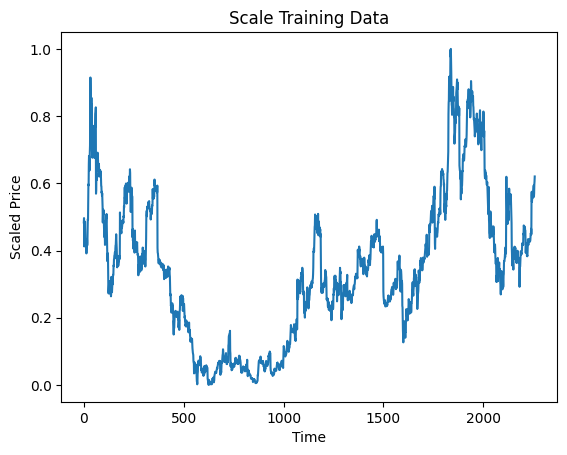

In [12]:
plt.plot(train_scaled)
plt.title('Scale Training Data')
plt.xlabel('Time')
plt.ylabel('Scaled Price')
plt.show()


In [13]:
#Prepare the training data

X_train = []
y_train = []
timesteps = 50

#Create the training datasets with specified timesteps

for i in range(timesteps,len(train_scaled)):
  X_train.append(train_scaled[i-timesteps:i,0])
  y_train.append(train_scaled[i,0])


In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

# Check again
assert not np.isnan(X_train).any(), "Found NaN in X_train!"
assert not np.isnan(y_train).any(), "Found NaN in y_train!"

In [15]:
#Convert into arrays

X_train,y_train = np.array(X_train),np.array(y_train)


In [16]:
#Reshape the input data in the suitable for RNN

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))


In [17]:
#Convert data into PYTorch tensors

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

In [18]:
#Define the RNN Model class

class RNNModel(nn.Module):
  def __init__(self):
    super(RNNModel,self).__init__()
    self.rnn1 = nn.RNN(
                       input_size=1,
                       hidden_size=50,
                       num_layers=1,
                       batch_first=True
                       )
    self.dropout1 = nn.Dropout(0.2)

    self.rnn2 = nn.RNN(
                       input_size=50,
                       hidden_size=50,
                       num_layers=1,
                       batch_first=True
                       )
    self.dropout2 = nn.Dropout(0.2)

    self.rnn3 = nn.RNN(
                       input_size=50,
                       hidden_size=50,
                       num_layers=1,
                       batch_first=True
                       )
    self.dropout3 = nn.Dropout(0.2)

    self.rnn4 = nn.RNN(
                       input_size=50,
                       hidden_size=50,
                       num_layers=1,
                       batch_first=True
                       )
    self.dropout4 = nn.Dropout(0.2)

    self.fc = nn.Linear(in_features=50,out_features=1)


  def forward(self,x):
      #pass through first RNN Layer
      out, _ = self.rnn1(x)
      out = self.dropout1(out)
      #pass through Second RNN Layer
      out, _ = self.rnn2(out)
      out = self.dropout2(out)
       #pass through third RNN Layer
      out, _ = self.rnn3(out)
      out = self.dropout3(out)
       #pass through forth RNN Layer
      out, _ = self.rnn4(out)
      out = self.dropout4(out)

      out = self.fc(out[:,-1,:]) # taks the output from trhe last time step and pass it to fully connected layer
      return out









In [19]:
#initialize the RNN model

regresssor = RNNModel()

In [20]:

#Define the loss function and Optimizer

criterion = nn.MSELoss()
# optimizer = optim.Adam(regresssor.parameters(),lr=0.001)
optimizer = optim.Adam(regresssor.parameters(), lr=0.0001)




In [21]:
epochs = 100
for epoch in range(epochs):
    regresssor.train()
    optimizer.zero_grad()
    output = regresssor(X_train)
    loss = criterion(output, y_train.view(-1, 1))

    if torch.isnan(loss) or torch.isinf(loss):
        print(f"Epoch {epoch+1}: Loss is NaN or Inf. Stopping training.")
        break

    loss.backward()

    # Check for exploding gradients
    for name, param in regresssor.named_parameters():
        if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
            print(f"NaN or Inf in gradient for parameter: {name}")
            break

    torch.nn.utils.clip_grad_norm_(regresssor.parameters(), max_norm=1.0)
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch: [10/100], Loss: 0.0995
Epoch: [20/100], Loss: 0.0545
Epoch: [30/100], Loss: 0.0565
Epoch: [40/100], Loss: 0.0518
Epoch: [50/100], Loss: 0.0499
Epoch: [60/100], Loss: 0.0446
Epoch: [70/100], Loss: 0.0412
Epoch: [80/100], Loss: 0.0356
Epoch: [90/100], Loss: 0.0280
Epoch: [100/100], Loss: 0.0187


RMSE: 6.5010
MAE: 4.9899


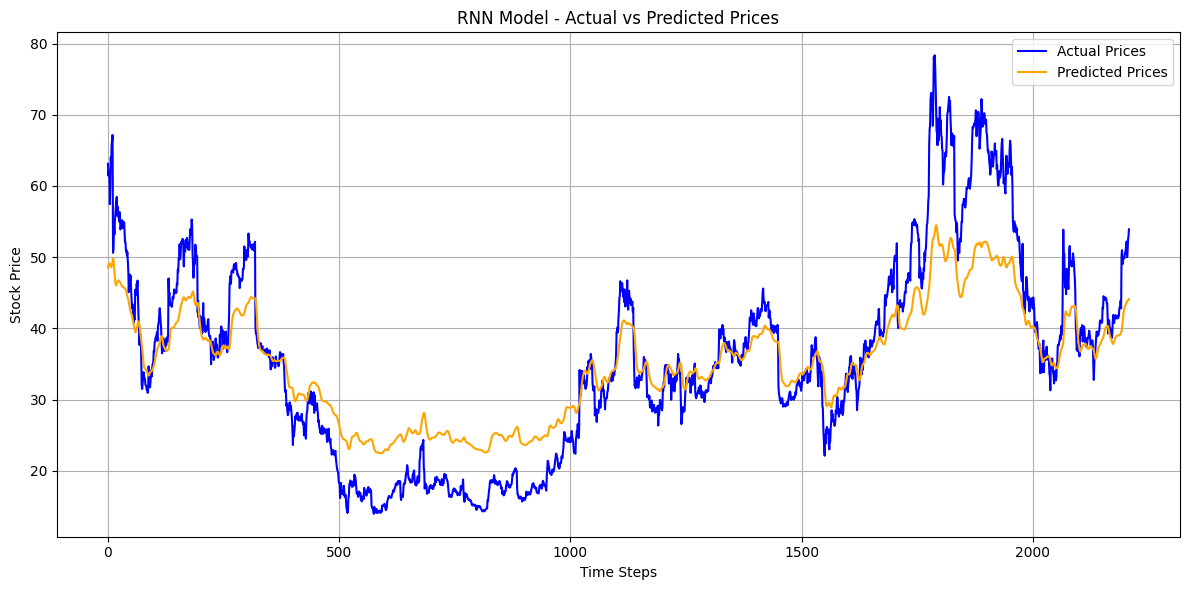

In [22]:

# Testing Data
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set model to evaluation mode
regresssor.eval()

# Disable gradient computation for evaluation?
with torch.no_grad():
    predictions = regresssor(X_train).cpu().numpy()

# Inverse transform the predictions and actual values back to original scale
predicted_prices = sc.inverse_transform(predictions)
actual_prices = sc.inverse_transform(y_train.view(-1, 1).cpu().numpy())

# Calculate Evaluation Metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.title('RNN Model - Actual vs Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Root Mean Squared Error (RMSE): 3.5987
Mean Absolute Error (MAE): 2.8105


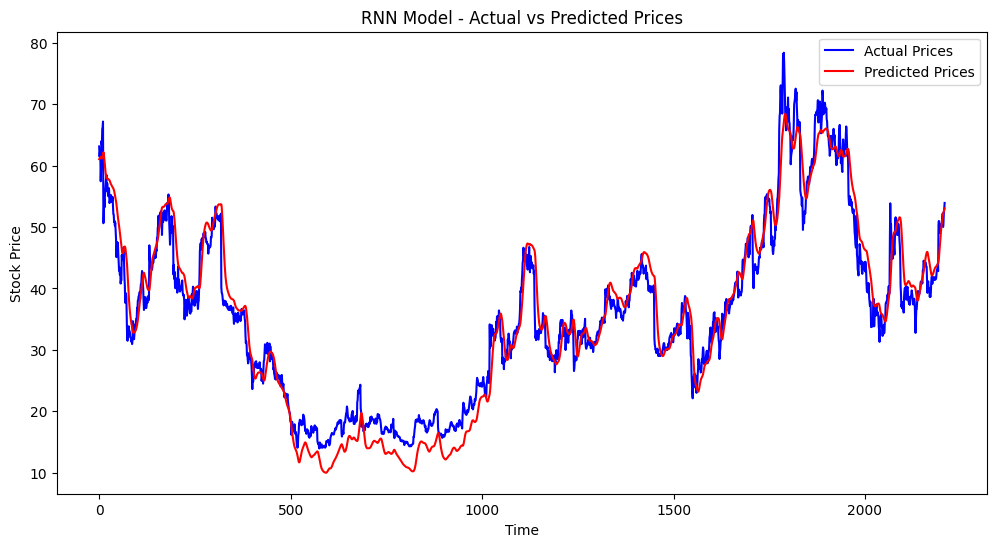

In [ ]:
#training data

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Set model to evaluation mode
regresssor.eval()

# Disable gradient calculation
with torch.no_grad():
    predictions = regresssor(X_train)

# Convert predictions and actual to numpy arrays
predictions = predictions.detach().numpy()
y_actual = y_train.detach().numpy()

# Inverse transform the scaled predictions and actual values
predicted_prices = sc.inverse_transform(predictions)
actual_prices = sc.inverse_transform(y_actual.reshape(-1, 1))

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('RNN Model - Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
